In [30]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Base Classes

<div style="color: green; font-weight:
bold">The code in the following cell is almost completely equivalent with the exception of the method find_thresholds. We forgot to take into account the n_mins and hence have other splits that are copnsidered. Performance wise this solution ought to be equivalent as well with only minor differences, like computing the indices in "make_children"twice instead of using the logical not.</div>

In [3]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            t = np.array(x)
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        sub_list = np.random.choice(D, size=D_try)
        return sub_list
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        test = np.array(node.features)
        sorted_feature = np.sort(np.unique(node.features[:,j]))
        thresholds = []
        for i in range(len(sorted_feature) - 1):
            threshold = (sorted_feature[i] + sorted_feature[i+1]) / 2  # Compute the midpoint between adjacent elements
            thresholds.append(threshold)
        return thresholds
        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()
        
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
                
        left.features = node.features[left_indices]
        right.features = node.features[right_indices]
                
        left.responses = node.responses[left_indices]
        right.responses = node.responses[right_indices]
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

<div style="color: green; font-weight:
bold">The following code cell is also almost identical in function and performance, however, the make-leaf node is quite different, as we used as predicted element the most predicted element of all leaf nodes and the sample solution used the mean of all leaf nodes, which is of course correct.</div>

In [4]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if len(left_indices) < self.n_min or len(right_indices) < self.n_min:
            return float("inf")

        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]

        left_mean = np.mean(left_responses)
        right_mean = np.mean(right_responses)
                
        left_sse = np.sum((left_responses - left_mean) ** 2)
        right_sse = np.sum((right_responses - right_mean) ** 2)
        total_sse = left_sse + right_sse

        return total_sse
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        unique, counts = np.unique(node.responses, return_counts=True)
        # Find the index of the element with the maximum count
        max_count_index = np.argmax(counts)
        # Get the element with the maximum count
        predicted_element = unique[max_count_index]
        node.prediction = predicted_element


# Classification Tree

<div style="color: green; font-weight:
bold">The compute loss function is equivalent. We used the gini impurity, whereas the sample solution used the cross entropy loss. Both are viable but different in calculation. The make leaf node function again is different. It again does not use the mean for predicting the element but uses solely the argmax, which is incorrect</div>

In [5]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # Return the loss if we would split the instances along feature j at threshold t,
        # or float('inf') if there is no feasible split.
        
        left_indices = node.features[:, j] <= t
        right_indices = node.features[:, j] > t
        
        if len(left_indices) < self.n_min or len(right_indices) < self.n_min:
            return float('inf')
        
        left_responses = node.responses[left_indices]
        right_responses = node.responses[right_indices]
                
        # Calculate the Gini impurity for the left and right subsets
        left_gini = self.calculate_gini_impurity(left_responses)
        right_gini = self.calculate_gini_impurity(right_responses)
        total_gini = (len(left_indices)) * left_gini + (len(right_indices)) * right_gini
        
        return total_gini
        
    def calculate_gini_impurity(self, responses):
        # Calculate the Gini impurity for each subnode and all classes
        
        _, counts = np.unique(responses, return_counts=True)
        probabilities = counts / len(responses)
        gini_impurity = 1.0 - np.sum(probabilities ** 2)
        
        return gini_impurity
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        unique_classes, counts = np.unique(node.responses, return_counts=True)

        # Filter the unique classes based on the permitted classes
        filtered_classes = np.intersect1d(unique_classes, self.classes)

        if len(filtered_classes) > 0:
            predicted_class_index = np.argmax(counts[unique_classes == filtered_classes])
            predicted_class = filtered_classes[predicted_class_index]
        else:
            # If no permitted class is present in the node's responses, select the most frequent class
            # no other useful use of self.classes came into my mind...
            predicted_class_index = np.argmax(counts)
            predicted_class = unique_classes[predicted_class_index]

        node.prediction = predicted_class

# Evaluation of Regression and Classification Tree

<div style="color: green; font-weight:
bold">Due to the differences in the implementation of the threshold and the make leaf nodes, the solutions are not as good as for the sample solution. Hence our error rate is higher than the sample one. Apart from that the function for cross validation are implemented correctly. This holds true for both implementations for the evaluation of the regression tree and the classification tree. Although we did not evaluate the test error for each fold and computed the mean. We just used it on the best performing hyperparameter once. On the other hand we did a hyperparameter testing for n_mins which hasn't been done in the sample solution.</div>

In [6]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [7]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results

ratio = 0.75
length = features.shape[0]
idx = round(ratio*length)

X_train, y_train = features[:idx], responses[:idx]
X_test, y_test = features[idx:], responses[idx:]

def regression_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = features[train], responses[train]
            X_val, y_val = features[val], responses[val]
            RegTree = RegressionTree(n_min=n_min)
            RegTree.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(RegTree.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

regression_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.12415824915824915, standard deviation: 0.06252089856814665
The mean error rate for training with n_min of 10: 0.17946127946127943, standard deviation: 0.05176541836249753
The mean error rate for training with n_min of 20: 0.12878787878787878, standard deviation: 0.046235037524779324
The mean error rate for training with n_min of 50: 0.10143097643097643, standard deviation: 0.020904420771359667


best result for n_min of 5, overall the error rate is decent but not as low as I wished for. Compared to the sample solution in ex1 for the same task with svm's, this has a similar error rate. Trainig time is very fast.

In [8]:
n_min = [5]
RegTree = RegressionTree(n_min[0])
RegTree.train(X_train, y_train, n_min)
y_preds = []
for sample in range(X_test.shape[0]):
    y_preds.append(RegTree.predict(X_test[sample]))
print(f"The test error with n_min of {n_min[0]}: {np.mean(y_preds != y_test)}")

The test error with n_min of 5: 0.25274725274725274


#### Classification Tree

In [9]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results

ratio = 0.75
length = features.shape[0]
idx = round(ratio*length)
classes = np.unique(labels)

X_train, y_train = features[:idx], labels[:idx]
X_test, y_test = features[idx:], labels[idx:]


def classification_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = features[train], labels[train]
            X_val, y_val = features[val], labels[val]
            ClassTree = ClassificationTree(n_min=n_min, classes=classes)
            ClassTree.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassTree.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

classification_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.13813131313131313, standard deviation: 0.0300450815164449
The mean error rate for training with n_min of 10: 0.1515151515151515, standard deviation: 0.07472168693997355
The mean error rate for training with n_min of 20: 0.11548821548821547, standard deviation: 0.06355034893763103
The mean error rate for training with n_min of 50: 0.129040404040404, standard deviation: 0.045372400521784984


best result for n_min = 20. Decent error rate especially for n_min = 20. The training time is a bit longer than for the regressiontree, which might be due to my implementation or due to the fact that it took more calculation steps. But still it was a fast training time with < 10 seconds 

In [10]:
n_min = [20]
ClassTree = ClassificationTree(n_min=n_min[0], classes = classes)
ClassTree.train(X_train, y_train, n_min)
y_preds = []
for sample in range(X_test.shape[0]):
    y_preds.append(ClassTree.predict(X_test[sample]))
print(f"The test error with n_min of {n_min[0]}: {np.mean(y_preds != y_test)}")

The test error with n_min of 20: 0.0989010989010989


# Regression and Classification Forest

<div style="color: green; font-weight:
bold">The bootstrapping function is quite similar with minor differences in the random initialization. This difference shouldn't effect the performance and functionality.</div>

In [11]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    
    assert features.shape[0] == responses.shape[0], "Feature and label shape don't match."
    # length of dataset
    N = responses.shape[0]
    indices = np.random.randint(low=0, high=N, size=N)
    # features and responses can be selected more than once 
    return features[indices], responses[indices]

In [12]:
bootstrap_features, bootstrap_responses = bootstrap_sampling(digits.data, digits.target)

print(bootstrap_features.shape, bootstrap_responses.shape)

(1797, 64) (1797,)


<div style="color: green; font-weight:
bold">The regression forest is implemented equivallently with respect to performance and functionality.</div>

In [13]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        responses = np.array([tree.predict(x=x) for tree in self.trees])
        # ensemble response regression: average over all tree responses
        return np.sign(np.mean(responses))
        


<div style="color: green; font-weight:
bold">The classification forest is implemented equivalently with only minor implementation differences in the predict function, which neither effect performance nor functionality.</div>

In [14]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, labels):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, labels)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        responses = np.array([tree.predict(x=x) for tree in self.trees])
        # count response for each unique class
        unique, counts = np.unique(responses, return_counts=True)
        # return class with most counts
        return unique[np.argmax(counts)]

# Evaluation of Regression and Decision Forest

<div style="color: green; font-weight:
bold">As described in the comment for the evaluation of the single trees, the function is correctly build with an additional hyperparameter testing and only slight functional differences (we did not print the train error for each fold). Due to the slight errors in the base tree implementation, the results are not as good as the ones in the sample solution. This applies also for the classification tree forest. </div>

In [15]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
X_train, X_test, y_train, y_test = train_test_split(features, responses, test_size=0.25)

def regression_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            RegForest = RegressionForest(n_trees=10, n_min=n_min)
            RegForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(RegForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

regression_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.06001683501683502, standard deviation: 0.02421946981906757
The mean error rate for training with n_min of 10: 0.04141414141414141, standard deviation: 0.02391402141768023
The mean error rate for training with n_min of 20: 0.05555555555555555, standard deviation: 0.047213143644377634
The mean error rate for training with n_min of 50: 0.07853535353535354, standard deviation: 0.027645717096820954


In [16]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
classes = np.unique(labels)

def classification_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(len(n_mins))
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=n_min)
            ClassForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

classification_cross_validation(X_train, y_train, [5, 10, 20, 50])

The mean error rate for training with n_min of 5: 0.0967171717171717, standard deviation: 0.027146040505130177
The mean error rate for training with n_min of 10: 0.050505050505050504, standard deviation: 0.02675126023917627
The mean error rate for training with n_min of 20: 0.07828282828282829, standard deviation: 0.023823184676910615
The mean error rate for training with n_min of 50: 0.06447811447811447, standard deviation: 0.04623258548561051


# Multi-class Classification Forest

In [17]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

features = digits.data
labels = digits.target

(1797, 64) (1797,)


In [18]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
classes = np.unique(labels)

def classification_cross_validation(X_train, y_train, n_mins):
    # safes the best n_min config
    min_n_min = None
    min_mean_error = float('inf')
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(n_folds)
        for i, (train, val) in enumerate(k_folds.split(X_train, y_train)):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]
            ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=n_min)
            ClassForest.train(train_X, train_y)
            y_preds = []
            for sample in range(X_val.shape[0]):
                y_preds.append(ClassForest.predict(X_val[sample]))
            mean_rate[i-1] = np.mean(y_preds != y_val)

        # Search for the n_min with the lowest mean_error  
        if np.mean(mean_rate) < min_mean_error:
            min_mean_error = np.mean(mean_rate)
            min_n_min = n_min
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")
    return min_n_min

In [19]:
min_n_min = classification_cross_validation(X_train, y_train, [2, 5, 10])
print(min_n_min)

The mean error rate for training with n_min of 2: 0.19669007297260088, standard deviation: 0.037029718682801964
The mean error rate for training with n_min of 5: 0.1825829547019138, standard deviation: 0.03600997969518495
The mean error rate for training with n_min of 10: 0.20482996007159576, standard deviation: 0.041249256100184234
5


In [20]:
ClassForest = ClassificationForest(n_trees=10, classes=classes, n_min=min_n_min)
ClassForest.train(X_train, y_train)

y_predictions = []
for i in range(len(X_test)):
    y_predictions.append(ClassForest.predict(X_test[i]))
y_predictions = np.array(y_predictions)

In [21]:
print(y_predictions[:10])
print(y_test[:10])

[7 4 2 4 3 5 8 6 9 0]
[7 4 2 4 3 5 9 6 5 0]


In [22]:
# Confusion Matrices
confusion_matrix = confusion_matrix(y_predictions, y_test)
print(confusion_matrix)

[[45  0  0  0  0  0  0  0  0  0]
 [ 0 47  0  0  2  1  3  0  3  3]
 [ 0  1 27  2  0  2  0  0  3  1]
 [ 0  1  2 40  1  4  0  1  1  0]
 [ 0  0  1  0 37  2  1  5  4  3]
 [ 2  0  0  0  1 29  0  2  3  3]
 [ 0  0  0  1  1  0 49  0  0  0]
 [ 0  0  0  0  2  4  0 30  1  3]
 [ 0  0  1  3  0  1  2  0 36  3]
 [ 1  1  0  0  0  1  0  0  2 25]]


In [23]:
# Confusion matrix plot taken from
# https://stackoverflow.com/questions/39033880/plot-confusion-matrix-sklearn-with-multiple-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

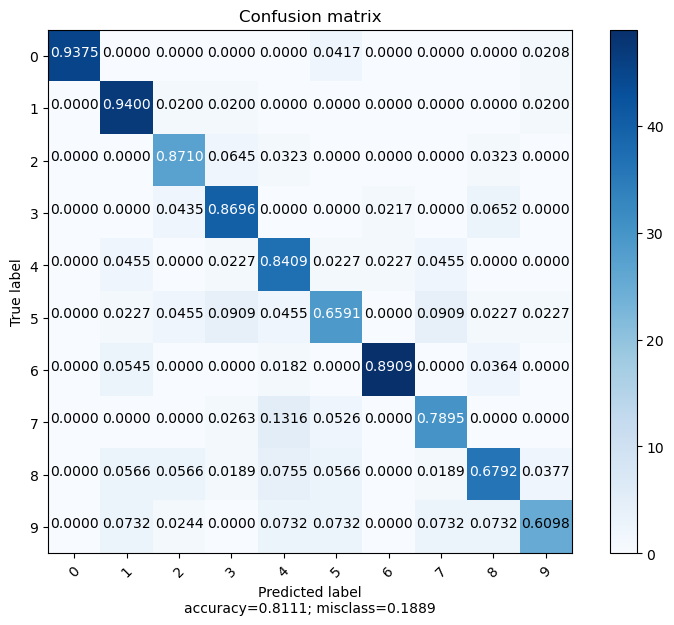

In [24]:
# confusion matrix for all digits
plot_confusion_matrix(confusion_matrix.T, [str(i) for i in range(10)])

For all digits the correct prediction is quite high. However it seams that for digits "4" and "8" prediction quality is lower. 
For digit "4" most incorrect classifications are mapped to "2" (6,5%) and "7" (8,7%) which is expected due to similarity of the digits.
For digit "8" most incorrect classifications are mapped to "3" (10,26%) which also is expected due to the similarity of "3" and "8".

# One-against-the-rest classification with RegressionForest

In [25]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

features = digits.data
labels = digits.target

(1797, 64) (1797,)


In [26]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

def regression_cross_validation(X_train, y_train, n_mins):
    for n_min in n_mins:
        n_folds = 5
        k_folds = KFold(n_splits=n_folds)
        mean_rate = np.zeros(n_folds)
        for i, (train, val) in tqdm(enumerate(k_folds.split(X_train, y_train))):
            train_X, train_y = X_train[train], y_train[train]
            X_val, y_val = X_train[val], y_train[val]

            reg_forest_list = []
            for digit in range(10):
                # for regression, we use labels +1 for digit and -1 for the rest
                responses = np.array([1 if l == digit else -1 for l in train_y])
                RegForest = RegressionForest(n_trees=10, n_min=n_min)
                RegForest.train(train_X, responses)
                reg_forest_list.append(RegForest)
                
            y_preds = []
            for sample in range(X_val.shape[0]):
                reg_forest_model_pred_list = []
                for reg_forest_model in reg_forest_list:
                    reg_forest_model_pred_list.append(reg_forest_model.predict(X_val[sample]))
                idx_pred = np.argmax(reg_forest_model_pred_list)
                if reg_forest_model_pred_list[idx_pred] <= 0:
                    y_preds.append(np.nan)
                else:
                    y_preds.append(idx_pred)
            y_preds = np.array(y_preds)
            mean_rate[i-1] = np.mean(y_preds != y_val)
        print(f"The mean error rate for training with n_min of {n_min}: {np.mean(mean_rate)}, standard deviation: {np.std(mean_rate)}")

regression_cross_validation(X_train, y_train, [5])

5it [00:38,  7.74s/it]

The mean error rate for training with n_min of 5: 0.23087429436871817, standard deviation: 0.03202328406488615


In [27]:
n_min = 5
reg_forest_list = []
for digit in range(10):
    # for regression, we use labels +1 for digit and -1 for the rest
    responses = np.array([1 if l == digit else -1 for l in y_train])
    RegForest = RegressionForest(n_trees=10, n_min=n_min)
    RegForest.train(X_train, responses)
    reg_forest_list.append(RegForest)
    
y_preds = []
for sample in range(X_test.shape[0]):
    reg_forest_model_pred_list = []
    for reg_forest_model in reg_forest_list:
        reg_forest_model_pred_list.append(reg_forest_model.predict(X_test[sample]))
    idx_pred = np.argmax(reg_forest_model_pred_list)
    if reg_forest_model_pred_list[idx_pred] <= 0:
        y_preds.append(10)
    else:
        y_preds.append(idx_pred)
y_preds = np.array(y_preds)

In [31]:
# Confusion Matrices
confusion_matrix_val = confusion_matrix(y_preds, y_test)
print(confusion_matrix_val)

[[36  0  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  2  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0  0 42  0  0  0  0  0]
 [ 0  0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0 25  0]
 [ 1  5  6 15 10 12  1  4 17 13  0]]


/var/folders/47/kf2nw7g97xj4bnnf6pdqwq640000gp/T/ipykernel_14875/2331623182.py:61: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


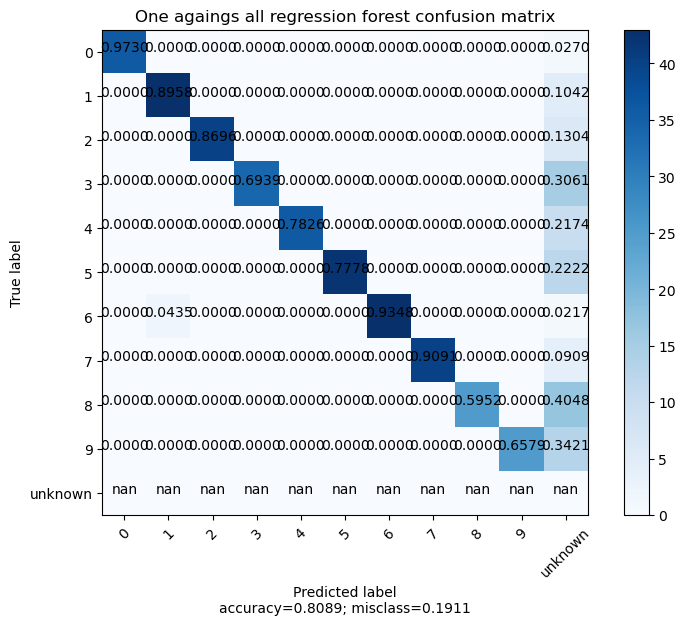

In [33]:
# confusion matrix for all digits
plot_confusion_matrix(
    confusion_matrix_val.T
    , [str(i) for i in range(10)] + ["unknown"]
    , title="One agaings all regression forest confusion matrix"
)

We can see, that the correct predictions are generally quite high. However, for digit 9, 8 and 3 the corresponding models are often unsure. Probably due to the fact, that those three digits are visually similar to each other. Also we can see that of course unknown true labels. 